### IMPORT

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import time
from datetime import datetime
import os
import math

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

### MV Values :

In [4]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_2025-03-11-09h48.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values    

### Optimal Parameters MV: 

In [5]:
Kp_FOPDTOPT_MV =  0.33306127817093445
T_FOPDTOPT_MV =  162.91388213046346
theta_FOPDTOPT_MV = 38.4580785282409

Kp_SOPDTOPT_MV = 0.31517342698205286
T1_SOPDTOPT_MV = 85.86981466605239
T2_SOPDTOPT_MV = 85.88390201063179
theta_SOPDTOPT_MV = 3.187352907789281  

Ts = 1

PV_SOPDTOPT_MV = SOPDT(MVm,Kp_SOPDTOPT_MV,T1_SOPDTOPT_MV,T2_SOPDTOPT_MV,theta_SOPDTOPT_MV,Ts)
PV_FOPDTOPT_MV = FOPDT(MVm,Kp_FOPDTOPT_MV,T_FOPDTOPT_MV,theta_FOPDTOPT_MV,Ts)


### Graphical data 

In [6]:
a = 0.08
t1 = 85
t2 = 123
Tu=36
Tg=186
Kp = 0.305


### Broida 1 :

In [7]:
T_B1 = Tg
theta1= Tu
PV_FOPDTBR1_MV = FOPDT(MVm,Kp,T_B1,theta1,Ts)

### Broida 2

In [8]:
T_B2 = 5.5*(t2-t1)
theta2= 2.8*t1-1.8*t2
PV_FOPDTBR2_MV = FOPDT(MVm,Kp,T_B2,theta2,Ts)
print('T_B2 = ',T_B2)

T_B2 =  209.0


### van der Grinten

In [9]:
Tvdg1 = Tg*((3*a*math.e-1)/(1+a*math.e))
Tvdg2 = Tg*((1-a*math.e)/(1+a*math.e))
thetavdg = Tu-((Tvdg1*Tvdg2)/(Tvdg1-3*Tvdg2))
print(Tvdg1,Tvdg2,thetavdg)
PV_SOPDTVDG_MV = SOPDT(MVm,Kp,Tvdg1,Tvdg2,thetavdg,Ts)

-53.10709506039477 119.55354753019736 20.580769611253203


### Strejc

In [10]:
ans = [0, 0.1, 0.22, 0.32]
bns = [1,2.72,3.69,4.46]
n = 0
div = Tu/Tg
for i in range(len(ans)-1) :
        if ans[i]<div<ans[i+1] :
            n = i
an=ans[n]
bn=bns[n]
TSM=Tg/bn
thetaSM=Tu-an*Tg
PV_FOPDTS_MV = FOPDT(MVm,Kp,TSM,thetaSM,Ts)


### Plot comparaison MV

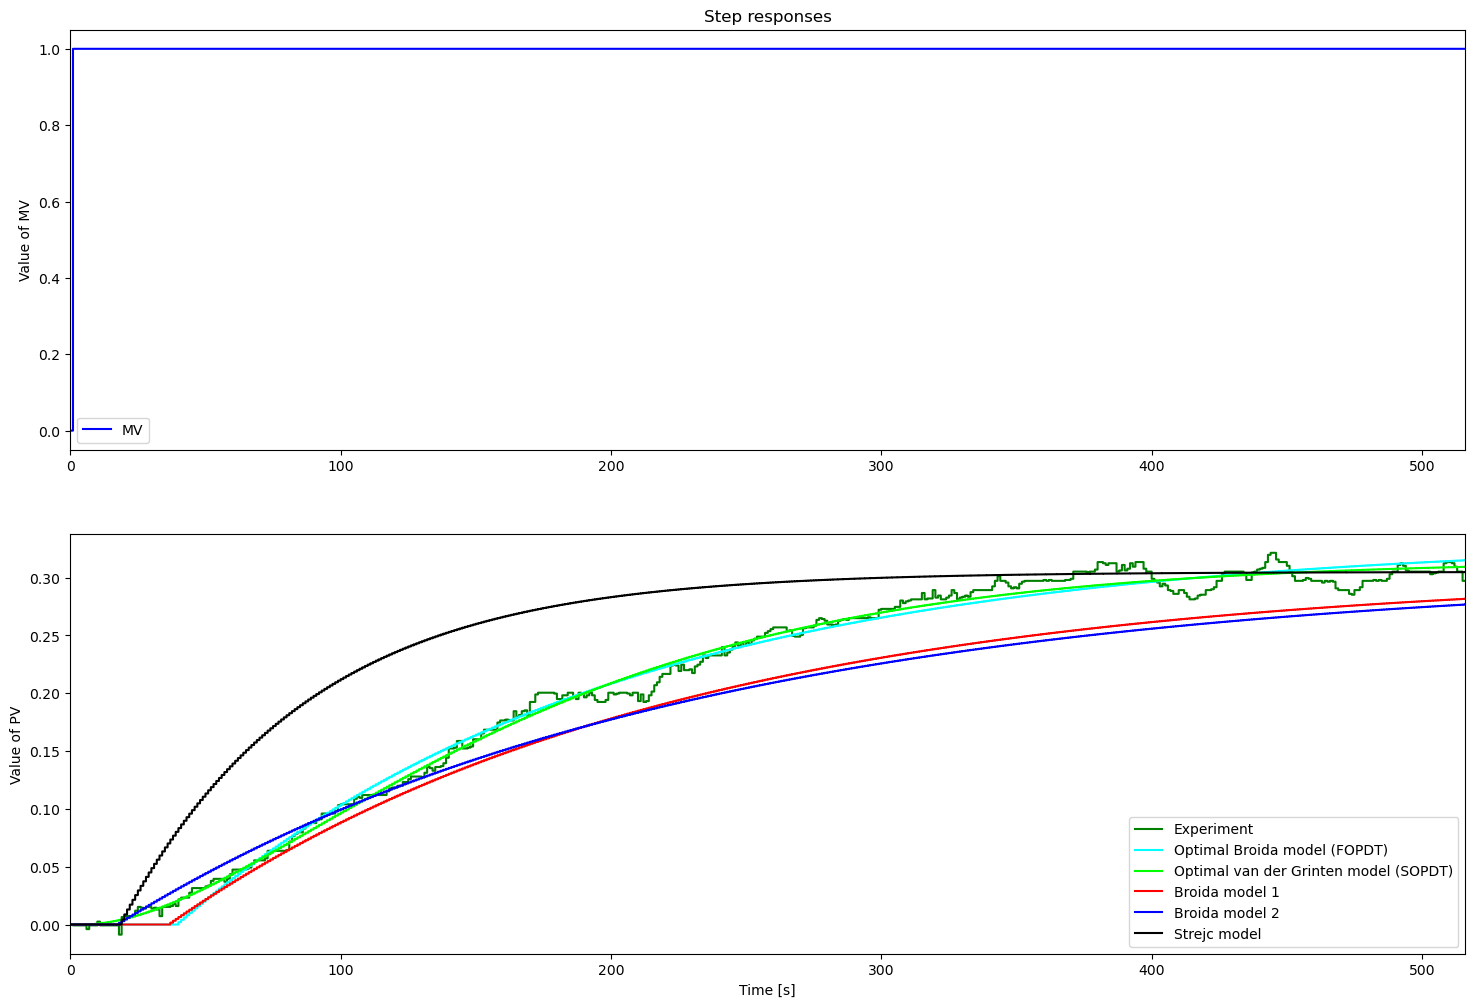

In [11]:
plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
plt.step(tm,MVm,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('Step responses')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',label='Experiment',where='post')
plt.step(tm,PV_FOPDTOPT_MV,'cyan',label='Optimal Broida model (FOPDT)',where='post')
plt.step(tm,PV_SOPDTOPT_MV,'lime',label='Optimal van der Grinten model (SOPDT)',where='post')
plt.step(tm,PV_FOPDTBR1_MV,'red', label='Broida model 1', where='post')
plt.step(tm,PV_FOPDTBR2_MV,'blue', label='Broida model 2', where='post')
#plt.step(tm,PV_SOPDTVDG_MV,'brown', label='van der Grinten model',where='post')
plt.step(tm,PV_FOPDTS_MV, 'black', label='Strejc model', where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')  
plt.xlim([0, np.max(tm)])
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'Comparaison_des_graphes' + date_time
plt.savefig('Plots//' + titleName + '.png',transparent=False)
plt.savefig('Plots//' + titleName + '.pdf',transparent=True)

### Compare Bode diagrams 

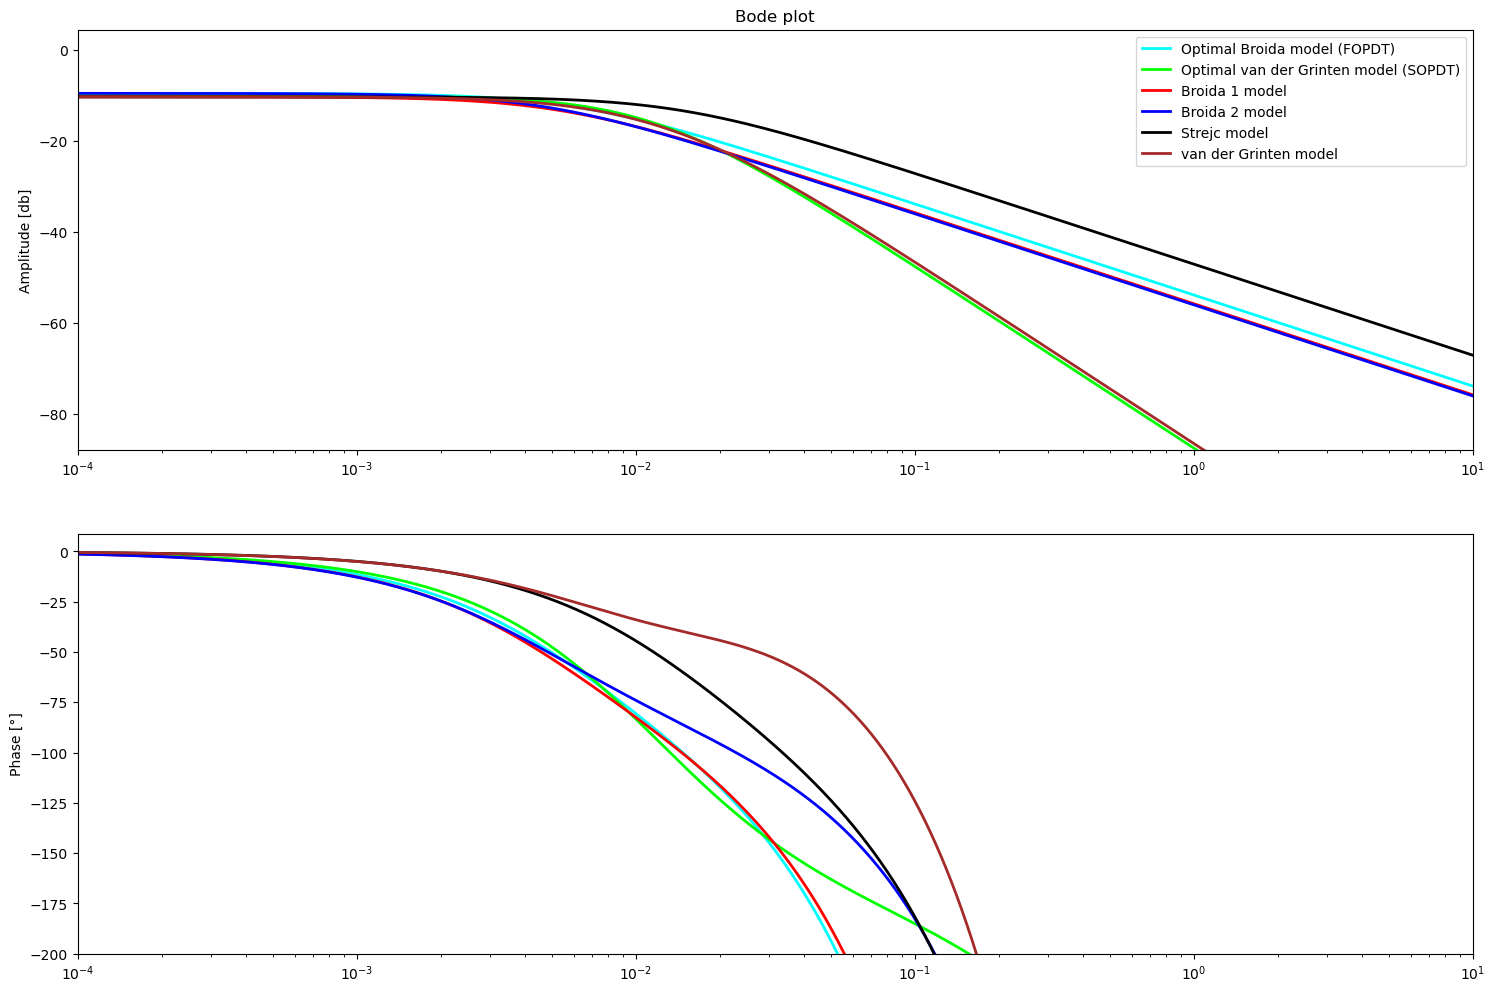

In [12]:
#Frequency response
P_FOPDTOPT = Process({})
P_FOPDTOPT.parameters['Kp'] = Kp_FOPDTOPT_MV
P_FOPDTOPT.parameters['Tlag1'] = T_FOPDTOPT_MV
P_FOPDTOPT.parameters['theta'] = theta_FOPDTOPT_MV

P_FOPDTBR1 = Process({})
P_FOPDTBR1.parameters['Kp'] = Kp
P_FOPDTBR1.parameters['Tlag1'] = T_B1
P_FOPDTBR1.parameters['theta'] = theta1

P_FOPDTBR2 = Process({})
P_FOPDTBR2.parameters['Kp'] = Kp_FOPDTOPT_MV
P_FOPDTBR2.parameters['Tlag1'] = T_B2
P_FOPDTBR2.parameters['theta'] = theta2

P_FOPDTSM = Process({})
P_FOPDTSM.parameters['Kp'] = Kp
P_FOPDTSM.parameters['Tlag1'] = TSM
P_FOPDTSM.parameters['theta'] = thetaSM



# Frequency response
P_SOPDTOPT = Process({})
P_SOPDTOPT.parameters['Kp'] = Kp_SOPDTOPT_MV
P_SOPDTOPT.parameters['Tlag1'] = T1_SOPDTOPT_MV
P_SOPDTOPT.parameters['Tlag2'] = T2_SOPDTOPT_MV
P_SOPDTOPT.parameters['theta'] = theta_SOPDTOPT_MV

P_SOPDTVDG = Process({})
P_SOPDTVDG.parameters['Kp'] = Kp
P_SOPDTVDG.parameters['Tlag1'] = Tvdg1
P_SOPDTVDG.parameters['Tlag2'] = Tvdg2
P_SOPDTVDG.parameters['theta'] = thetavdg

omega = np.logspace(-4, 1, 10000)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) # Optimal Broida
Ps_FOPDTBR1 = Bode(P_FOPDTBR1,omega,False)
Ps_FOPDTBR2 = Bode(P_FOPDTBR2,omega,False)
Ps_FOPDTSM = Bode(P_FOPDTSM,omega,False)
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,False) # Optimal van der 
Ps_SOPDTVDG = Bode(P_SOPDTVDG,omega,False)

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_FOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_FOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'cyan',linewidth=2,label='Optimal Broida model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'lime',linewidth=2,label='Optimal van der Grinten model (SOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTBR1)),'red',linewidth=2,label='Broida 1 model')
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTBR2)),'blue',linewidth=2,label='Broida 2 model')
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTSM)),'black',linewidth=2,label='Strejc model')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTVDG)),'brown',linewidth=2,label='van der Grinten model')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'cyan',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'lime',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTBR1)),'red',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTBR2)),'blue',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTSM)),'black',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTVDG)),'brown',linewidth=2)
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'Bode_diagramme' + date_time
plt.savefig('Plots//' + titleName + '.png',transparent=False)
plt.savefig('Plots//' + titleName + '.pdf',transparent=True)